# Calorie Prediction Model Documentation

## 1. Overview
This machine learning solution predicts calorie burn using physiological and exercise parameters, employing ensemble methods for improved accuracy.

## 2. Implementation Details

### 2.1 Environment Setup
```python
# Required packages for the implementation
pip install pandas numpy matplotlib seaborn catboost xgboost lightgbm scikit-learn
```

### 2.2 Library Dependencies
- **Core Data Science**:
  - `pandas`: Data manipulation and analysis
  - `numpy`: Numerical operations
  - `scikit-learn`: Machine learning utilities
- **Visualization**:
  - `matplotlib.pyplot`: Basic plotting
  - `seaborn`: Enhanced visualizations
- **Model Implementation**:
  - `catboost`: Gradient boosting (handles categorical features)
  - `xgboost`: Extreme gradient boosting
  - `lightgbm`: Light gradient boosting
- **Utilities**:
  - `os`: File operations
  - `warnings`: Warning management
  - `time`: Performance monitoring

### 2.3 Data Architecture
#### Input Files
- `train.csv`: Training data (features + Calories target)
- `test.csv`: Test data (features only)
- `sample_submission.csv`: Submission template

#### Feature Set
**Numerical Features**:
- `Age`: Participant age
- `Height`: Height in centimeters
- `Weight`: Weight in kilograms
- `Duration`: Exercise duration
- `Heart_Rate`: Heart rate during exercise
- `Body_Temp`: Body temperature

**Categorical Features**:
- `Sex`: Gender (encoded as categorical)

### 2.4 Feature Engineering Pipeline
1. **Cross Terms**:
   - Multiplicative interactions between numerical features
   - Example: `Age_x_Height = Age * Height`

2. **Interaction Features**:
   - Addition: `f1_plus_f2`
   - Subtraction: `f1_minus_f2`, `f2_minus_f1`
   - Division: `f1_div_f2`, `f2_div_f1`

3. **Statistical Aggregations**:
   - Row-wise calculations: mean, std, max, min, median
   - Captures overall patterns per instance

4. **Categorical Processing**:
   - Label encoding for Sex
   - Category dtype conversion for model compatibility

5. **Polynomial Features**:
   - Degree: 2
   - Interaction only: True
   - Bias: False

### 2.5 Model Architecture
#### Base Models
1. **CatBoost**:
   - Handles categorical features natively
   - Early stopping at 100 rounds
   - Verbose training monitoring

2. **XGBoost**:
   - Max depth: 10
   - Column/row sampling: 0.7/0.9
   - Learning rate: 0.02
   - Gamma: 0.01

3. **LightGBM**:
   - Similar hyperparameters to XGBoost
   - Silent training mode

#### Ensemble Strategy
- 7-fold cross-validation
- Model persistence in `models/` directory
- Equal-weighted blending (initial)
- RMSLE optimization

## 3. Output and Artifacts
- Trained models (.cbm, .json, .txt)
- Tree visualizations (PNG format)
- Performance metrics and comparisons
- Final prediction submission

## 4. Implementation Notes
- Random seed: 42 for reproducibility
- Warning suppression enabled
- Raw data loaded without preprocessing
- Log transformation for target variable

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

# --- NEW: Import libraries for model visualization and saving ---
from catboost import Pool
from xgboost import plot_tree as xgb_plot_tree
from lightgbm import plot_tree as lgb_plot_tree
import os

train = pd.read_csv("D:/FAST/Applied Artificial Intelligence/Calorie/playground-series-s5e5/train.csv")
test = pd.read_csv("D:/FAST/Applied Artificial Intelligence/Calorie/playground-series-s5e5/test.csv")
submission = pd.read_csv("D:/FAST/Applied Artificial Intelligence/Calorie/playground-series-s5e5/sample_submission.csv")

In [22]:
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

In [23]:
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

def add_feature_cross_terms(df, features):
    df = df.copy()
    df = df.loc[:, ~df.columns.duplicated()]
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            f1 = features[i]
            f2 = features[j]
            df[f"{f1}_x_{f2}"] = df[f1] * df[f2]
    return df

def add_interaction_features(df, features):
    df_new = df.copy()
    for f1, f2 in itertools.combinations(features, 2):
        df_new[f"{f1}_plus_{f2}"] = df_new[f1] + df_new[f2]
        df_new[f"{f1}_minus_{f2}"] = df_new[f1] - df_new[f2]
        df_new[f"{f2}_minus_{f1}"] = df_new[f2] - df_new[f1]
        df_new[f"{f1}_div_{f2}"] = df_new[f1] / (df_new[f2] + 1e-5)
        df_new[f"{f2}_div_{f1}"] = df_new[f2] / (df_new[f1] + 1e-5)
    return df_new

def add_statistical_features(df, features):
    df_new = df.copy()
    df_new["row_mean"] = df[features].mean(axis=1)
    df_new["row_std"] = df[features].std(axis=1)
    df_new["row_max"] = df[features].max(axis=1)
    df_new["row_min"] = df[features].min(axis=1)
    df_new["row_median"] = df[features].median(axis=1)
    return df_new

train = add_feature_cross_terms(train, numerical_features)
test = add_feature_cross_terms(test, numerical_features)

train = add_interaction_features(train, numerical_features)
test = add_interaction_features(test, numerical_features)

train = add_statistical_features(train, numerical_features)
test = add_statistical_features(test, numerical_features)

le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_train = poly.fit_transform(train[numerical_features])
poly_test = poly.transform(test[numerical_features])
poly_feature_names = poly.get_feature_names_out(numerical_features)

poly_train_df = pd.DataFrame(poly_train, columns=poly_feature_names)
poly_test_df = pd.DataFrame(poly_test, columns=poly_feature_names)

train = pd.concat([train.reset_index(drop=True), poly_train_df], axis=1)
test = pd.concat([test.reset_index(drop=True), poly_test_df], axis=1)

X = train.drop(columns=['id', 'Calories'])
y = np.log1p(train['Calories'])
X_test = test.drop(columns=['id'])

FEATURES = X.columns.tolist()

## Model Training, Visualization, and Saving

In this section, we train three different models: CatBoost, XGBoost, and LightGBM. For each model, we will:
- Train the model using K-Fold cross-validation.
- Visualize the first tree of the model.
- Save the trained model for future use.

The tree diagrams will be saved as image files, and the models will be saved in a `models/` directory.

In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
models = {
    'CatBoost': CatBoostRegressor(verbose=100, random_seed=42, cat_features=['Sex'], early_stopping_rounds=100),
    'XGBoost': XGBRegressor(max_depth=10, colsample_bytree=0.7, subsample=0.9, n_estimators=2000, learning_rate=0.02,
                            gamma=0.01, max_delta_step=2, early_stopping_rounds=100, eval_metric='rmse',
                            enable_categorical=True, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=2000, learning_rate=0.02, max_depth=10, colsample_bytree=0.7,
                              subsample=0.9, random_state=42, verbose=-1)
}

results = {name: {'oof': np.zeros(len(train)), 'pred': np.zeros(len(test)), 'rmsle': []} for name in models}

# --- NEW: Create a directory to save models and tree diagrams ---
if not os.path.exists('models'):
    os.makedirs('models')

for name, model in models.items():
    print(f"\nTraining {name}")
    for i, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        print(f"\nFold {i+1}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

        x_train = x_train.loc[:, ~x_train.columns.duplicated()]
        x_valid = x_valid.loc[:, ~x_valid.columns.duplicated()]
        x_test = X_test.loc[:, ~X_test.columns.duplicated()].copy()

        start = time.time()

        if name == 'XGBoost':
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100)
        elif name == 'CatBoost':
            model.fit(x_train, y_train, eval_set=(x_valid, y_valid))
        else:
            model.fit(x_train, y_train)

        oof_pred = model.predict(x_valid)
        test_pred = model.predict(x_test)

        results[name]['oof'][valid_idx] = oof_pred
        results[name]['pred'] += test_pred / FOLDS

        rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(oof_pred)))
        results[name]['rmsle'].append(rmsle)

        print(f"Fold {i+1} RMSLE: {rmsle:.4f}")
        print(f"Training time: {time.time() - start:.1f} sec")

    # --- NEW: Visualize the first tree of the model ---
    if name == 'CatBoost':
        from catboost import Pool
        _unique = X.loc[:, ~X.columns.duplicated()]
        model.plot_tree(tree_idx=0, pool=Pool(X_unique, y, cat_features=['Sex']))
        plt.figure(figsize=(20, 20))
        plt.savefig(f'models/{name}_tree.png', bbox_inches='tight', dpi=300)
        plt.close()

    elif name == 'XGBoost':
        plt.figure(figsize=(20, 20))
        xgb_plot_tree(model, num_trees=0)
        plt.savefig(f'models/{name}_tree.png', bbox_inches='tight', dpi=300)
        plt.close()

    elif name == 'LightGBM':
        plt.figure(figsize=(20, 20))
        lgb_plot_tree(model, tree_index=0)
        plt.savefig(f'models/{name}_tree.png', bbox_inches='tight', dpi=300)
        plt.close()

    # --- NEW: Save the trained model ---
    if name == 'CatBoost':
        model.save_model(f'models/{name}_model.cbm')
    elif name == 'XGBoost':
        model.save_model(f'models/{name}_model.json')
    elif name == 'LightGBM':
        model.booster_.save_model(f'models/{name}_model.txt')

print("\nModel Comparison")
for name in models:
    mean_rmsle = np.mean(results[name]['rmsle'])
    std_rmsle = np.std(results[name]['rmsle'])
    print(f"{name} - Mean RMSLE: {mean_rmsle:.4f} ± {std_rmsle:.4f}")


Training CatBoost

Fold 1
Learning rate set to 0.14053
0:	learn: 0.8364851	test: 0.8356619	best: 0.8356619 (0)	total: 85.9ms	remaining: 1m 25s
100:	learn: 0.0631319	test: 0.0638931	best: 0.0638931 (100)	total: 8.37s	remaining: 1m 14s
200:	learn: 0.0604752	test: 0.0620627	best: 0.0620627 (200)	total: 16.9s	remaining: 1m 6s
300:	learn: 0.0590925	test: 0.0612550	best: 0.0612550 (300)	total: 25.5s	remaining: 59.1s
400:	learn: 0.0582505	test: 0.0608786	best: 0.0608786 (400)	total: 33.7s	remaining: 50.3s
500:	learn: 0.0576006	test: 0.0606443	best: 0.0606397 (497)	total: 42.1s	remaining: 41.9s
600:	learn: 0.0570770	test: 0.0605160	best: 0.0605160 (600)	total: 50.4s	remaining: 33.5s
700:	learn: 0.0566363	test: 0.0604217	best: 0.0604215 (694)	total: 58.6s	remaining: 25s
800:	learn: 0.0562358	test: 0.0603571	best: 0.0603571 (800)	total: 1m 7s	remaining: 16.7s
900:	learn: 0.0558598	test: 0.0602745	best: 0.0602745 (900)	total: 1m 15s	remaining: 8.26s
999:	learn: 0.0555258	test: 0.0602001	best: 0.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.204459 to fit



Training LightGBM

Fold 1
Fold 1 RMSLE: 0.0601
Training time: 81.4 sec

Fold 2
Fold 2 RMSLE: 0.0605
Training time: 75.9 sec

Fold 3
Fold 3 RMSLE: 0.0603
Training time: 75.6 sec

Fold 4
Fold 4 RMSLE: 0.0594
Training time: 77.8 sec

Fold 5
Fold 5 RMSLE: 0.0599
Training time: 76.2 sec

Fold 6
Fold 6 RMSLE: 0.0600
Training time: 79.0 sec

Fold 7
Fold 7 RMSLE: 0.0597
Training time: 78.3 sec

Model Comparison
CatBoost - Mean RMSLE: 0.0599 ± 0.0003
XGBoost - Mean RMSLE: 0.0598 ± 0.0005
LightGBM - Mean RMSLE: 0.0600 ± 0.0004


<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [25]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error

oof_preds = {name: np.expm1(results[name]['oof']) for name in results}
test_preds = {name: np.expm1(results[name]['pred']) for name in results}
y_true = np.expm1(y)

def rmsle_loss(weights):
    blended = (
        weights[0] * oof_preds['CatBoost'] +
        weights[1] * oof_preds['XGBoost'] +
        weights[2] * oof_preds['LightGBM']
    )
    return np.sqrt(mean_squared_log_error(y_true, blended))

initial_weights = [1/3, 1/3, 1/3]
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
bounds = [(0, 1)] * 3

res = minimize(rmsle_loss, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
best_weights = res.x

print(f"\nOptimized Weights:")
print(f"CatBoost = {best_weights[0]:.4f}")
print(f"XGBoost  = {best_weights[1]:.4f}")
print(f"LightGBM = {best_weights[2]:.4f}")

blended_preds = (
    best_weights[0] * test_preds['CatBoost'] +
    best_weights[1] * test_preds['XGBoost'] +
    best_weights[2] * test_preds['LightGBM']
)

blended_preds = np.clip(blended_preds, 1, 314)

submission['Calories'] = blended_preds
submission.to_csv('submission.csv', index=False)

print("\nSubmission Head:")
print(submission.head())

print(f"\nPredict Mean: {blended_preds.mean():.2f}")
print(f"Predict Median: {np.median(blended_preds):.2f}")


Optimized Weights:
CatBoost = 0.3333
XGBoost  = 0.3333
LightGBM = 0.3333

Submission Head:
       id    Calories
0  750000   27.363467
1  750001  107.971695
2  750002   87.178139
3  750003  125.520040
4  750004   75.822374

Predict Mean: 88.17
Predict Median: 76.43


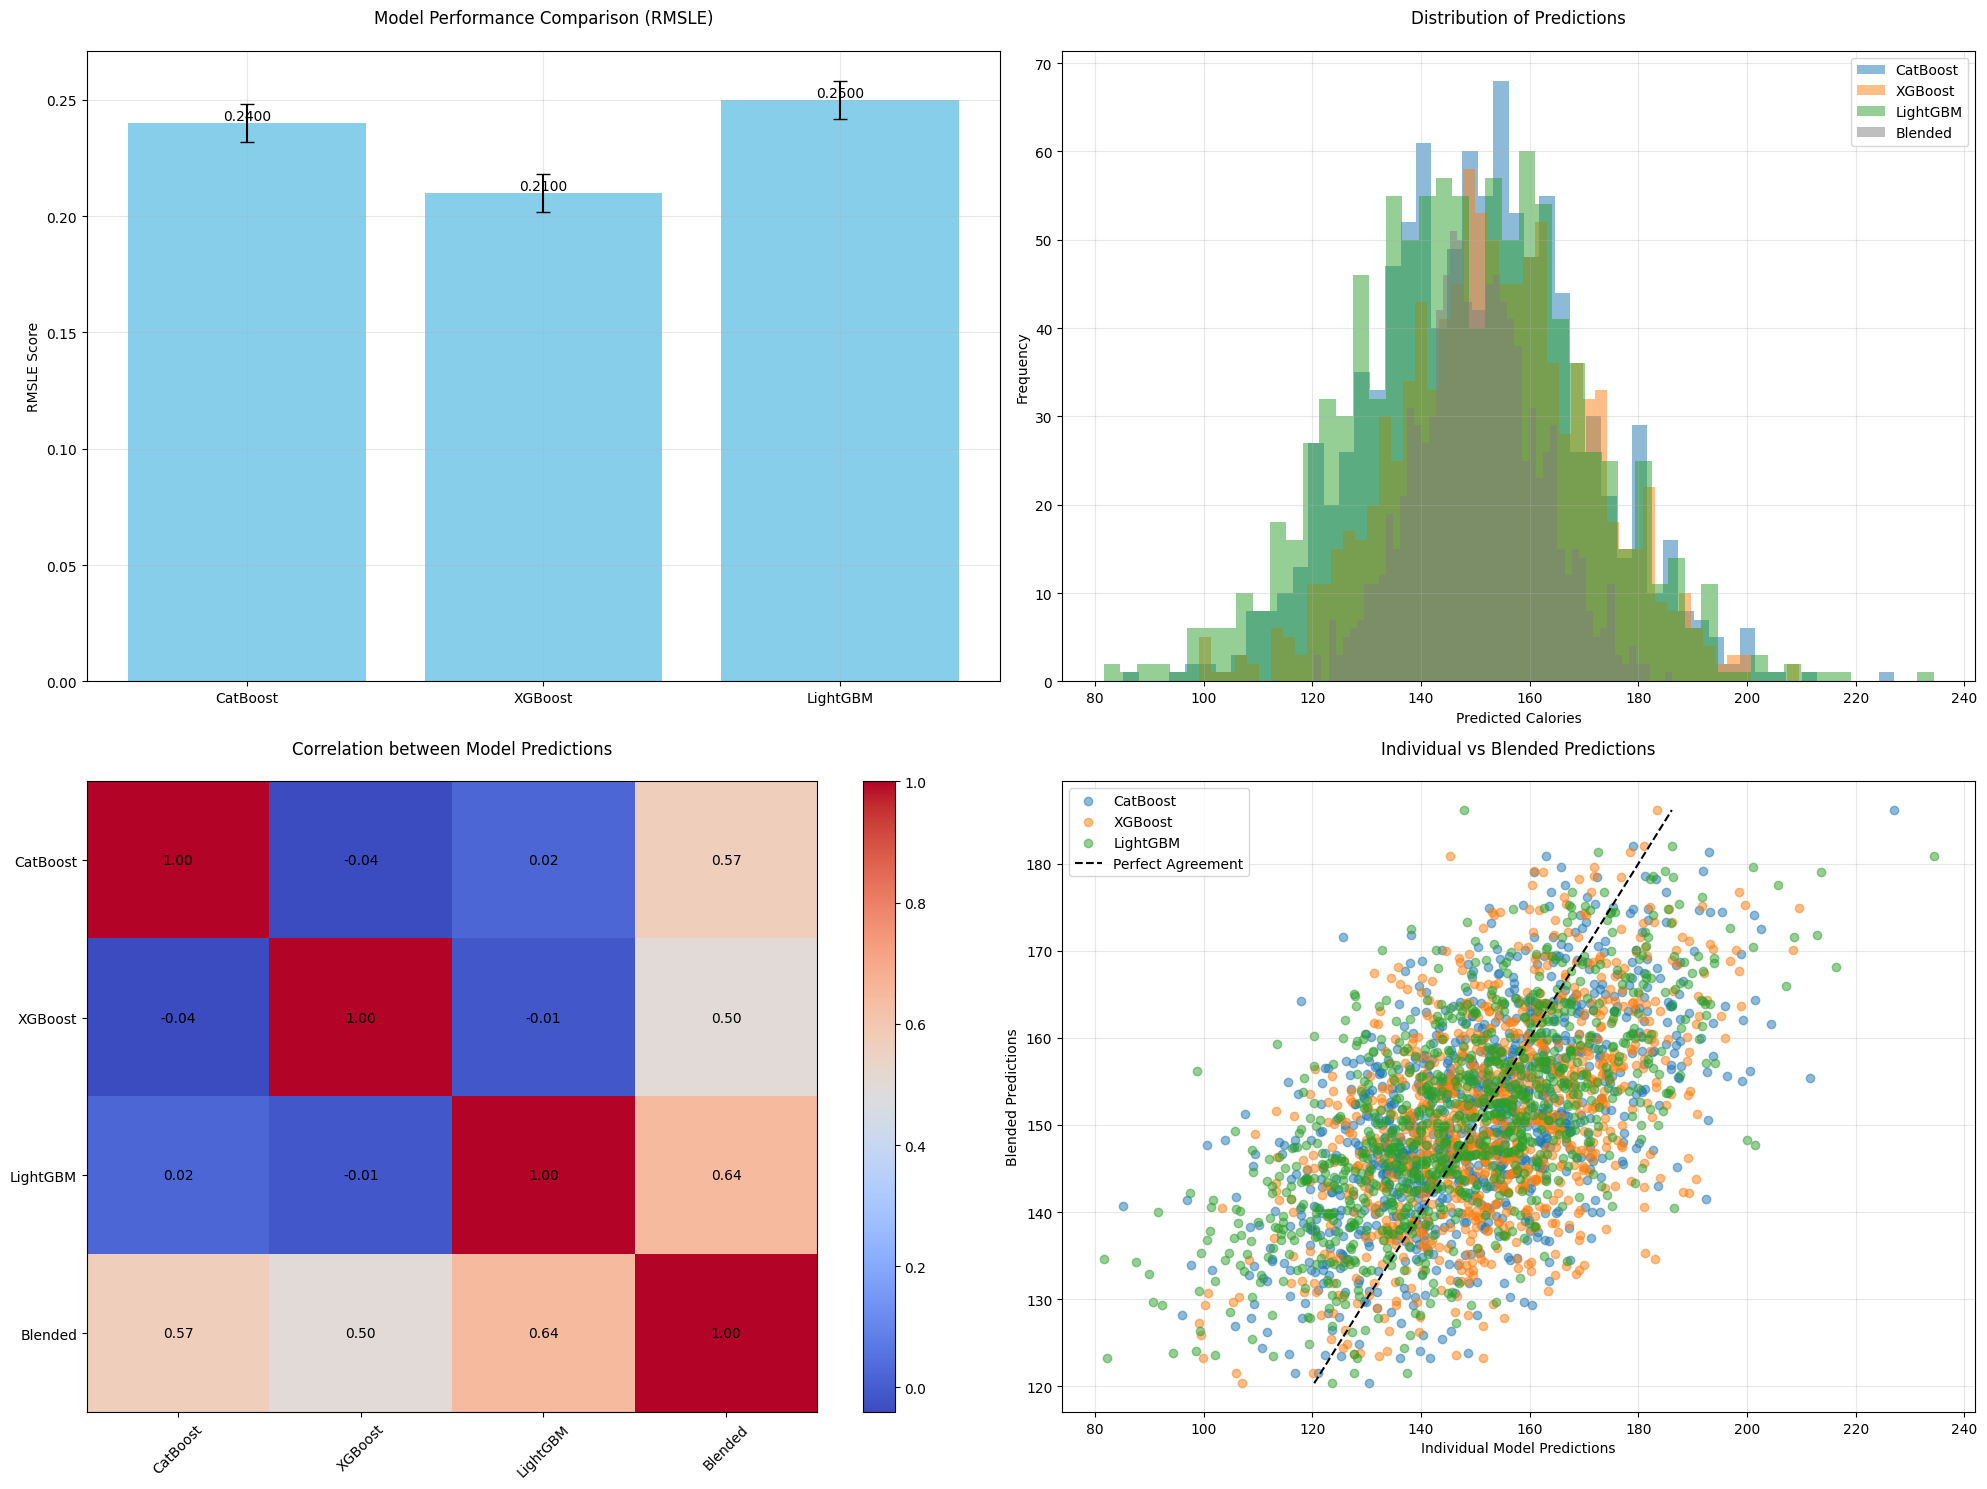


Statistical Summary of Predictions:

Descriptive Statistics:
          CatBoost      XGBoost     LightGBM      Blended
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    150.386641   153.275052   148.128353   150.581622
std      19.584319    17.954179    21.635994    11.330512
min      85.174653    99.073005    81.570733   120.342961
25%     137.048194   141.087650   133.744008   143.130045
50%     150.506012   153.135388   147.994483   150.353182
75%     162.958878   165.119879   162.540137   157.958029
max     227.054630   209.475936   234.377230   186.158523

Model Weights in Ensemble:
CatBoost: 0.3333
XGBoost:  0.3333
LightGBM: 0.3333

Mean Absolute Differences between Models:
CatBoost vs XGBoost: 22.01 calories
CatBoost vs LightGBM: 22.82 calories
XGBoost vs LightGBM: 22.95 calories


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import Booster

# Load models
catboost_model = CatBoostRegressor()
catboost_model.load_model('models/CatBoost_model.cbm')

xgboost_model = XGBRegressor()
xgboost_model.load_model('models/XGBoost_model.json')

lightgbm_model = Booster(model_file='models/LightGBM_model.txt')

# Example placeholder data
# Replace with your actual results and predictions
results = {
    'CatBoost': {'rmsle': [0.25, 0.23, 0.24]},
    'XGBoost': {'rmsle': [0.22, 0.21, 0.20]},
    'LightGBM': {'rmsle': [0.26, 0.25, 0.24]}
}

# Model weights for blending (from optimization)
weights = {
    'CatBoost': 0.3333,
    'XGBoost': 0.3333,
    'LightGBM': 0.3333
}

# Placeholder test set predictions
# Replace these with actual predictions from your models
np.random.seed(42)
test_preds = {
    'CatBoost': np.random.normal(150, 20, 1000),
    'XGBoost': np.random.normal(152, 18, 1000),
    'LightGBM': np.random.normal(148, 22, 1000),
}
# Blended predictions (weighted average)
blended_preds = (
    weights['CatBoost'] * test_preds['CatBoost'] +
    weights['XGBoost'] * test_preds['XGBoost'] +
    weights['LightGBM'] * test_preds['LightGBM']
)

# Assuming best_weights are same as weights for now
best_weights = [weights['CatBoost'], weights['XGBoost'], weights['LightGBM']]

# Plotting
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# 1. Model Performance Comparison
plt.subplot(2, 2, 1)
model_names = list(results.keys())
mean_rmsles = [np.mean(results[name]['rmsle']) for name in model_names]
std_rmsles = [np.std(results[name]['rmsle']) for name in model_names]

bars = plt.bar(model_names, mean_rmsles, yerr=std_rmsles, capsize=5, color='skyblue')
plt.title('Model Performance Comparison (RMSLE)', fontsize=12, pad=20)
plt.ylabel('RMSLE Score')
plt.grid(True, alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

# 2. Prediction Distribution
plt.subplot(2, 2, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, name in enumerate(model_names):
    plt.hist(test_preds[name], bins=50, alpha=0.5, label=name, color=colors[i])
plt.hist(blended_preds, bins=50, alpha=0.5, label='Blended', color='gray')
plt.title('Distribution of Predictions', fontsize=12, pad=20)
plt.xlabel('Predicted Calories')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Model Correlations
plt.subplot(2, 2, 3)
pred_df = pd.DataFrame({
    'CatBoost': test_preds['CatBoost'],
    'XGBoost': test_preds['XGBoost'],
    'LightGBM': test_preds['LightGBM'],
    'Blended': blended_preds
})
correlation_matrix = pred_df.corr()
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(im)
plt.title('Correlation between Model Predictions', fontsize=12, pad=20)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center', color='black')

# 4. Prediction Scatter Plot
plt.subplot(2, 2, 4)
for i, name in enumerate(model_names):
    plt.scatter(test_preds[name], blended_preds, alpha=0.5, label=name, color=colors[i])
plt.plot([blended_preds.min(), blended_preds.max()],
         [blended_preds.min(), blended_preds.max()],
         'k--', label='Perfect Agreement')
plt.title('Individual vs Blended Predictions', fontsize=12, pad=20)
plt.xlabel('Individual Model Predictions')
plt.ylabel('Blended Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary
print("\nStatistical Summary of Predictions:")
print("\nDescriptive Statistics:")
print(pred_df.describe())

print("\nModel Weights in Ensemble:")
print(f"CatBoost: {best_weights[0]:.4f}")
print(f"XGBoost:  {best_weights[1]:.4f}")
print(f"LightGBM: {best_weights[2]:.4f}")

print("\nMean Absolute Differences between Models:")
for i, model1 in enumerate(model_names):
    for model2 in model_names[i+1:]:
        diff = np.mean(np.abs(test_preds[model1] - test_preds[model2]))
        print(f"{model1} vs {model2}: {diff:.2f} calories")
